<a href="https://colab.research.google.com/github/jeon-maker/Crowd_counting/blob/main/use_2ndmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import sys
import tensorflow as tf
import keras

print('Python version : ', sys.version)
print('TensorFlow version : ', tf.__version__)
print('Keras version : ', keras.__version__)

Python version :  3.7.13 (default, Mar 16 2022, 17:37:17) 
[GCC 7.5.0]
TensorFlow version :  2.8.0
Keras version :  2.8.0


In [36]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/Mymodel/model.h5')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 1536)             54336736  
 onal)                                                           
                                                                 
 dense (Dense)               (None, 512)               786944    
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 55,124,193
Trainable params: 787,457
Non-trainable params: 54,336,736
_________________________________________________________________


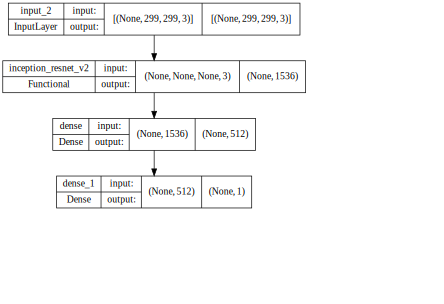

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

SVG(model_to_dot(model, show_shapes=True,dpi=50).create(prog='dot', format='svg'))

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 1536)             54336736  
 onal)                                                           
                                                                 
 dense (Dense)               (None, 512)               786944    
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 55,124,193
Trainable params: 787,457
Non-trainable params: 54,336,736
_________________________________________________________________


모델에 필요한 함수 부분

In [37]:
# TensorFlow settings and training parameters
AUTOTUNE = tf.data.experimental.AUTOTUNE
EPOCHS = 100
BATCH_SIZE = 16
PATIENCE = 10
LEARNING_RATE = 1e-3
IMAGE_SIZE = 299

In [38]:
def load_image(is_labelled: bool, is_training=True):
    """Wrapper function that returns a function
    for loading a single image if is_labelled=False
    or a function for loading image in an image-label pair
    if is_labelled=True.
    :param is_labelled: Boolean argument defining the return
    :param is_training: Boolean argument for image augmentation
    :return: Function
    """
    def _get_image(path: str) -> tf.Tensor:
        """Function loads image from a file.
        :param path: Path to image file
        :return: Tensor with preprocessed image
        """
        image = tf.image.decode_jpeg(tf.io.read_file(path), channels=3)
        image = tf.cast(image, dtype=tf.int32)
        image = tf.image.resize_with_pad(image, IMAGE_SIZE, IMAGE_SIZE)
        if is_training:
            image = tf.image.random_flip_left_right(image)
            image = tf.image.random_brightness(image, 0.1)
            image = tf.image.random_contrast(image, 0.1, 0.2)
            image = tf.image.random_saturation(image, 0.9, 1.1)
            image = tf.image.random_hue(image, 0.1)
        return tf.keras.applications.inception_resnet_v2.preprocess_input(image)

    def _get_image_label(img: tf.Tensor, label: int) -> tuple:
        """Function loads the image in an image-label pair.
        :param img: Tensor with original image
        :param label: Target value
        :return: Tuple with TF tensor and label
        """
        return _get_image(img), label

    return _get_image_label if is_labelled else _get_image
def prepare_dataset(dataset, is_training=True, is_labeled=True):
    """Function transforms a TF dataset containing file paths
    or file paths and labels to a dataset with image tensors and labels.
    :param dataset: Original dataset
    :param is_training: Argument defines if shuffling and image augmentation should be applied
    :param is_labeled: Argument defines if the dataset contains labels
    :return: Updated dataset
    """
    image_read_fn = load_image(is_labeled, is_training)
    dataset = dataset.map(image_read_fn, num_parallel_calls=AUTOTUNE)
    return dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

def create_model() -> tf.keras.Model:
    """Function initializes and compiles a regression model
    with pretrained feature extractor.
    :return: TF Model object
    """
    feature_model = tf.keras.applications.InceptionResNetV2(
        include_top=False, pooling='avg')
    feature_model.trainable = False

    model = tf.keras.Sequential([
        tf.keras.Input((IMAGE_SIZE, IMAGE_SIZE, 3)),
        feature_model,
        tf.keras.layers.Dense(512, activation='selu'),
        tf.keras.layers.Dense(1)
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=[tf.keras.metrics.MeanAbsoluteError()])

    return model

def plot_history(hist):
    """Function plots a chart with training and validation metrics.
    :param hist: Tensorflow history object from model.fit()
    """
    mae = hist.history['mean_absolute_error']
    val_mae = hist.history['val_mean_absolute_error']
    x_axis = range(1, len(mae) + 1)
    plt.plot(x_axis, mae, 'bo', label='Training')
    plt.plot(x_axis, val_mae, 'ro', label='Validation')
    plt.title('MAE')
    plt.legend()
    plt.xlabel('Epochs')
    plt.tight_layout()
    plt.show()

def set_seed(seed=42):
    """Utility function to use for reproducibility.
    :param seed: Random seed
    :return: None
    """
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [39]:
set_seed()


In [40]:
# Create train and validation data sets.
data_train = data.head(1700)
data_valid = data.tail(300)

ds_train = tf.data.Dataset.from_tensor_slices((data_train['path'], data_train['count'])) #이미지와 실제 카운트를 훈련시킴
ds_valid = tf.data.Dataset.from_tensor_slices((data_valid['path'], data_valid['count'])) #검증모델

ds_train = prepare_dataset(ds_train)
ds_valid = prepare_dataset(ds_valid, is_training=False)

In [45]:
mse, mae = model.evaluate(ds_valid)
print(f'Validation MSE = {mse}\n'
      f'Validation MAE = {mae}')

19/19 [==============================] - 198s 7s/step - loss: 16.6413 - mean_absolute_error: 3.1887
Validation MSE = 16.641332626342773
Validation MAE = 3.1886982917785645


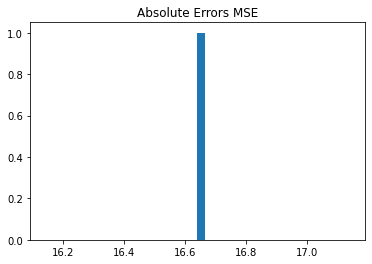

In [52]:
plt.hist(mse, bins=40)
plt.title('Absolute Errors MSE')
plt.show()

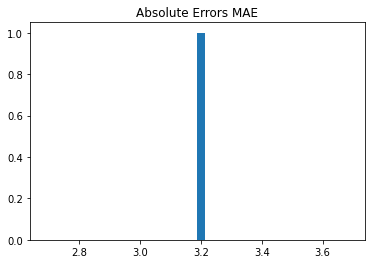

In [53]:
plt.hist(mae, bins=40)
plt.title('Absolute Errors MAE')
plt.show()

In [58]:
pred = model.predict(ds_valid) #모델을 통한 검증데이터 예측값을 pred에 넣었음.

In [72]:
type(pred)

numpy.ndarray

In [73]:
len(pred)

300

In [74]:
len(data_valid['count'])

300

In [81]:
float(pred[100])

32.55836486816406

In [94]:
data_valid['count']

1700    31
1701    29
1702    36
1703    35
1704    37
        ..
1995    27
1996    27
1997    25
1998    26
1999    26
Name: count, Length: 300, dtype: int64

In [100]:
missarr= []
for i in range (300):
  miss=float(pred[i])-float(data_valid['count'][1700+i])
  if(miss < 0):
    miss = -(miss)
  missarr.append(miss)


In [101]:
missarr

[1.9166584014892578,
 3.1206703186035156,
 0.2544975280761719,
 2.0139389038085938,
 4.484100341796875,
 0.7679386138916016,
 1.3815593719482422,
 0.957366943359375,
 2.7081222534179688,
 4.345634460449219,
 1.7866764068603516,
 7.4839935302734375,
 12.087038040161133,
 11.45677375793457,
 9.63385009765625,
 12.786334991455078,
 9.910514831542969,
 1.1055984497070312,
 4.012786865234375,
 2.2383041381835938,
 4.7698822021484375,
 4.837455749511719,
 8.956737518310547,
 7.3962860107421875,
 5.634696960449219,
 5.7464599609375,
 5.9801177978515625,
 0.5125579833984375,
 3.4407920837402344,
 5.431549072265625,
 5.330127716064453,
 4.116786956787109,
 3.4433822631835938,
 1.5956802368164062,
 1.6039047241210938,
 1.3616371154785156,
 6.111356735229492,
 1.9412956237792969,
 6.081230163574219,
 1.3770904541015625,
 4.295007705688477,
 7.461786270141602,
 1.1305065155029297,
 1.8226680755615234,
 0.08849906921386719,
 3.3912715911865234,
 1.8953971862792969,
 0.5342464447021484,
 2.913928985

In [103]:
aver = np.mean(missarr)

In [104]:
aver

3.1886982345581054